Here, we examine parametric sensitivity of the structure model on a small simulated dataset

In [1]:
import autograd

import autograd.numpy as np
import autograd.scipy as sp
from numpy.polynomial.hermite import hermgauss

from vb_lib import structure_model_lib, data_utils, cavi_lib
import vb_lib.structure_optimization_lib as str_opt_lib
from vb_lib.preconditioner_lib import get_mfvb_cov

import paragami
import vittles

from copy import deepcopy

import argparse
import distutils.util

import os

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib


/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/autograd/core.py:290: UserWarning: 
The defvjp method is deprecated. See the update guide and tutorial:
https://github.com/HIPS/autograd/blob/master/docs/updateguide.md
https://github.com/HIPS/autograd/blob/master/docs/tutorial.md
  warnings.warn(deprecation_msg)


In [2]:
np.random.seed(53453)

# Draw data

In [3]:
n_obs = 50
n_loci = 100
n_pop = 4

In [4]:
g_obs, true_pop_allele_freq, true_ind_admix_propn = \
    data_utils.draw_data(n_obs, n_loci, n_pop)

Text(0.5, 0, 'individual')

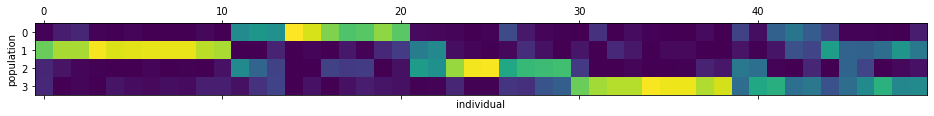

In [5]:
plt.matshow(true_ind_admix_propn.T)
plt.ylabel('population')
plt.xlabel('individual')

In [6]:
g_obs.shape

(50, 100, 3)

# Get prior

In [7]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_paragami)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

OrderedDict:
	[dp_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_beta] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


# Get VB params 

In [8]:
k_approx = 8

In [9]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [10]:
use_logitnormal_sticks = True

vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                    use_logitnormal_sticks = use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (100, 8, 2) (lb=0.0, ub=inf)
	[ind_mix_stick_propn_mean] = NumericArrayPattern (50, 7) (lb=-inf, ub=inf)
	[ind_mix_stick_propn_info] = NumericArrayPattern (50, 7) (lb=0.0001, ub=inf)


## Initialize 

In [11]:
vb_params_dict = \
        structure_model_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict,
                                                use_logitnormal_sticks)

In [12]:
def get_vb_expectations(vb_params_dict, use_logitnormal_sticks): 
    if use_logitnormal_sticks: 
        e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(
                            vb_params_dict['ind_mix_stick_propn_mean'], 
                            vb_params_dict['ind_mix_stick_propn_info'],
                            gh_loc, gh_weights)

    else: 
        ind_mix_stick_beta_params = vb_params_dict['ind_mix_stick_beta_params']
        e_stick_lengths = \
                modeling_lib.get_e_beta(ind_mix_stick_beta_params)
        e_ind_admix = cluster_quantities_lib.get_mixture_weights_from_stick_break_propns(e_stick_lengths)

    e_pop_freq = modeling_lib.get_e_beta(vb_params_dict['pop_freq_beta_params'])
    
    return e_ind_admix, e_pop_freq

Text(0.5, 0, 'individual')

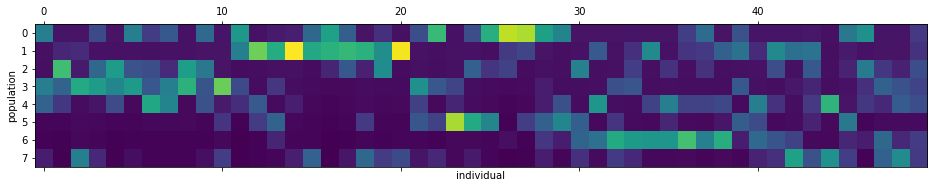

In [13]:
plt.matshow(get_vb_expectations(vb_params_dict, use_logitnormal_sticks)[0].transpose())
plt.ylabel('population')
plt.xlabel('individual')

# Run CAVI

In [14]:
# get beta parameters for sticks and populations
vb_opt_dict, vb_opt, ez_opt, kl_path, time_vec = \
    cavi_lib.run_cavi(g_obs, vb_params_dict, 
                        vb_params_paragami, 
                        prior_params_dict,
                        use_logitnormal_sticks, 
                        gh_loc = gh_loc, gh_weights = gh_weights,
                        max_iter = 1000,
                        x_tol = 1e-3, 
                        print_every = 20)


iteration [20]; kl:7602.104705; elapsed: 0.5248secs
iteration [40]; kl:7564.639784; elapsed: 0.5136secs
iteration [60]; kl:7541.840946; elapsed: 0.6116secs
iteration [80]; kl:7529.606602; elapsed: 0.5126secs
iteration [100]; kl:7521.16576; elapsed: 0.5451secs
iteration [120]; kl:7498.451598; elapsed: 0.4958secs
iteration [140]; kl:7494.317148; elapsed: 0.5008secs
iteration [160]; kl:7492.981089; elapsed: 0.6385secs
iteration [180]; kl:7491.628808; elapsed: 0.5079secs
iteration [200]; kl:7488.434971; elapsed: 0.5894secs
iteration [220]; kl:7483.683139; elapsed: 0.542secs
iteration [240]; kl:7477.437709; elapsed: 0.6166secs
iteration [260]; kl:7461.148045; elapsed: 0.5612secs
iteration [280]; kl:7434.763537; elapsed: 0.5917secs
iteration [300]; kl:7432.352247; elapsed: 0.5132secs
iteration [320]; kl:7428.580407; elapsed: 0.4995secs
iteration [340]; kl:7417.048586; elapsed: 0.5139secs
iteration [360]; kl:7401.451989; elapsed: 0.4923secs
iteration [380]; kl:7394.069221; elapsed: 0.4948secs

# Check out the fit

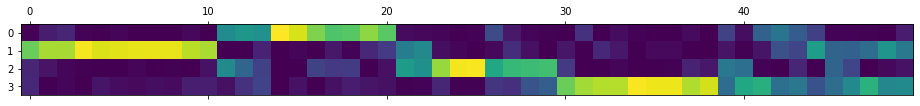

In [17]:
# truth
plt.matshow(true_ind_admix_propn.T)

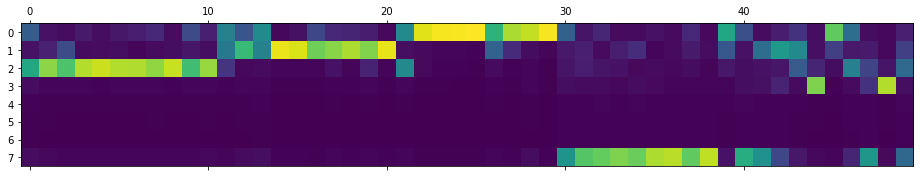

In [18]:
# fitted
e_ind_admix = get_vb_expectations(vb_opt_dict, use_logitnormal_sticks)[0]
plt.matshow(e_ind_admix.T)

# Define sensitivity object

In [19]:
# initial prior alpha
use_free_alpha = True
prior_alpha0 = prior_params_paragami['dp_prior_alpha'].flatten(prior_params_dict['dp_prior_alpha'], 
                                                              free = use_free_alpha)

In [20]:
# set up objective as function of vb params and prior param 

def objective_fun(vb_params_dict, alpha): 
    
    _prior_params_dict = deepcopy(prior_params_dict)
    _prior_params_dict['dp_prior_alpha'] = alpha
    
    return structure_model_lib.get_kl(g_obs, vb_params_dict, _prior_params_dict,
                    use_logitnormal_sticks,
                    gh_loc = gh_loc, gh_weights = gh_weights)


objective_fun_free = paragami.FlattenFunctionInput(
                                original_fun=objective_fun, 
                                patterns = [vb_params_paragami, prior_params_paragami['dp_prior_alpha']],
                                free = [True, use_free_alpha],
                                argnums = [0, 1])


In [21]:
# get preconditioner 
t0 = time.time()
mfvb_preconditioner = \
    get_mfvb_cov(vb_opt_dict, vb_params_paragami, use_logitnormal_sticks, return_info = True)

print('preconditioner time: {:0.3}sec'.format(time.time() - t0))

preconditioner time: 0.223sec


In [22]:
# get solver 
obj_fun_hvp = autograd.hessian_vector_product(objective_fun_free, argnum = 0)

hess_solver = vittles.solver_lib.get_cg_solver(lambda x : obj_fun_hvp(vb_opt, prior_alpha0, x), 
                                                        dim = len(vb_opt), 
                                                        cg_opts={'M':mfvb_preconditioner})


In [24]:
t0 = time.time()
vb_sens = \
    vittles.HyperparameterSensitivityLinearApproximation(
        objective_fun = objective_fun_free, 
        opt_par_value = vb_opt, 
        hyper_par_value = prior_alpha0, 
        hess_solver = hess_solver)

print('Total time: ', time.time() - t0)


cross hess time:  0.9082562923431396
solver time:  3.4165666103363037
Total time:  4.325208425521851


# Perturb alpha. Check results

In [25]:
# set new alpha 
new_alpha = np.array([5.])

prior_params_pert_dict = deepcopy(prior_params_dict)
prior_params_pert_dict['dp_prior_alpha'] = new_alpha


In [26]:
print('initial alpha, ', prior_params_dict['dp_prior_alpha'])
print('perturbed alpha, ', prior_params_pert_dict['dp_prior_alpha'])


initial alpha,  [3.]
perturbed alpha,  [5.]


In [27]:
# linear response prediction 
lr_vb_free_params = \
    vb_sens.predict_opt_par_from_hyper_par(
        prior_params_paragami['dp_prior_alpha'].flatten(prior_params_pert_dict['dp_prior_alpha'], 
                                                        free = use_free_alpha))

print('l_inf diff: ', np.max(np.abs(lr_vb_free_params - vb_opt)))


l_inf diff:  5.972801469928095


### reoptimize

In [28]:
new_init_dict = deepcopy(vb_opt_dict)
new_init_free = vb_params_paragami.flatten(new_init_dict, free = True)

In [29]:
vb_pert_dict, vb_opt_pert, e_z_pert = \
    cavi_lib.run_cavi(g_obs, deepcopy(new_init_dict), 
                                            vb_params_paragami,
                                            prior_params_pert_dict,
                                            use_logitnormal_sticks, 
                                            gh_loc = gh_loc, gh_weights = gh_weights,
                                            max_iter = 1000,
                                            x_tol = 1e-4, 
                                            print_every = 20)[0:3]

iteration [20]; kl:7622.157409; elapsed: 0.4964secs
iteration [40]; kl:7620.744635; elapsed: 0.6508secs
iteration [60]; kl:7620.684627; elapsed: 0.4969secs
iteration [80]; kl:7620.675271; elapsed: 0.4827secs
iteration [100]; kl:7620.673049; elapsed: 0.4852secs
iteration [120]; kl:7620.672429; elapsed: 0.5454secs
iteration [140]; kl:7620.672258; elapsed: 0.4879secs
iteration [160]; kl:7620.672205; elapsed: 0.4762secs
CAVI done. Termination after 163 steps in 4.19 seconds


### compare

In [30]:
def print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt): 
    plt.plot(lr_vb_free_params - vb_opt, 
             vb_opt_pert - vb_opt, 
             '+', color = 'red')

    plt.plot(lr_vb_free_params - vb_opt, 
            lr_vb_free_params - vb_opt, 
             '-', color = 'blue')

    plt.xlabel('lr')
    plt.ylabel('re-optimized')


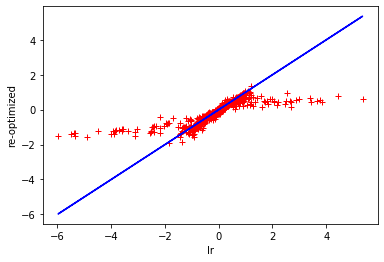

In [31]:
# compare free parameters
print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt)

In [32]:
# compare expectations
init_e_ind_admix, init_e_pop_freq = get_vb_expectations(vb_opt_dict, use_logitnormal_sticks)
pert_e_ind_admix, pert_e_pop_freq = get_vb_expectations(vb_pert_dict, use_logitnormal_sticks)
lr_e_ind_admix, lr_e_pop_freq = get_vb_expectations(vb_params_paragami.fold(lr_vb_free_params, free = True), 
                                                    use_logitnormal_sticks)

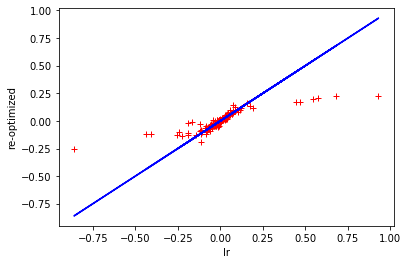

In [33]:
print_diff_plot(lr_e_ind_admix, pert_e_ind_admix, init_e_ind_admix)

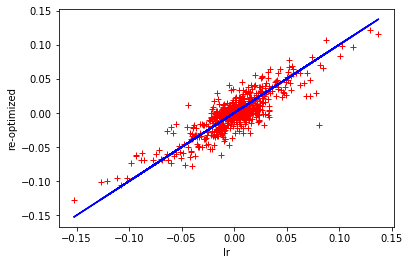

In [34]:
print_diff_plot(lr_e_pop_freq, pert_e_pop_freq, init_e_pop_freq)

In [35]:
print('init number of cluster: ', cluster_quantities_lib.get_e_num_clusters_from_ez(init_e_ind_admix))

print('pert number of cluster: ', cluster_quantities_lib.get_e_num_clusters_from_ez(pert_e_ind_admix))
print('lr number of cluster: ', cluster_quantities_lib.get_e_num_clusters_from_ez(lr_e_ind_admix))

init number of cluster:  5.901201976367991
pert number of cluster:  6.162381695605512
lr number of cluster:  6.064266382168583


In [36]:
# ez_init = cavi_lib.get_ez_from_vb_params_dict(g_obs, vb_opt_dict, use_logitnormal_sticks)
# ez_pert = cavi_lib.get_ez_from_vb_params_dict(g_obs, vb_pert_dict, use_logitnormal_sticks)
# ez_lr = cavi_lib.get_ez_from_vb_params_dict(g_obs, vb_params_paragami.fold(lr_vb_free_params, free = True), 
#                                                     use_logitnormal_sticks)


# _ez_init = ez_init.transpose(0, 1, 3, 2).reshape(-1, 8)
# _ez_pert = ez_pert.transpose(0, 1, 3, 2).reshape(-1, 8)
# _ez_lr = ez_lr.transpose(0, 1, 3, 2).reshape(-1, 8)

# print('init number of cluster: ', cluster_quantities_lib.get_e_num_clusters_from_ez(_ez_init))
# print('pert number of cluster: ', cluster_quantities_lib.get_e_num_clusters_from_ez(_ez_pert))
# print('lr number of cluster: ', cluster_quantities_lib.get_e_num_clusters_from_ez(_ez_lr))

# Fit for a range of alpha

In [37]:
alpha_list = np.arange(1, 8)

In [38]:
def refit_with_alpha(alpha, new_init_dict):
    # sets new alpha, returns new vb optimum
    
    # set new prior
    new_alpha = np.array([alpha])

    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['dp_prior_alpha'] = new_alpha
    
    vb_opt_pert = cavi_lib.run_cavi(g_obs, deepcopy(new_init_dict), 
                                    vb_params_paragami,
                                    prior_params_pert_dict,
                                    use_logitnormal_sticks, 
                                    gh_loc = gh_loc, gh_weights = gh_weights, 
                                    max_iter = 1000,
                                    x_tol = 1e-3, 
                                    print_every = 20)[1]

        
    return vb_opt_pert


In [39]:
print('alphas: ', alpha_list)

alphas:  [1 2 3 4 5 6 7]


In [40]:
vb_pert_list = []
for alpha in alpha_list: 
    print('\n re-optimzing with alpha = ', alpha)
    
    vb_pert_list.append(refit_with_alpha(alpha, new_init_dict))



 re-optimzing with alpha =  1
iteration [20]; kl:6910.095022; elapsed: 0.5106secs
iteration [40]; kl:6904.37878; elapsed: 0.5782secs
iteration [60]; kl:6902.768595; elapsed: 0.4843secs
iteration [80]; kl:6899.148759; elapsed: 0.4818secs
iteration [100]; kl:6898.696712; elapsed: 0.4672secs
iteration [120]; kl:6898.662387; elapsed: 0.5509secs
iteration [140]; kl:6898.64552; elapsed: 0.4744secs
iteration [160]; kl:6898.633098; elapsed: 0.4818secs
iteration [180]; kl:6898.61876; elapsed: 0.6111secs
iteration [200]; kl:6898.598054; elapsed: 0.4745secs
iteration [220]; kl:6898.573183; elapsed: 0.6663secs
iteration [240]; kl:6898.548237; elapsed: 0.6161secs
iteration [260]; kl:6898.527651; elapsed: 0.532secs
iteration [280]; kl:6898.514103; elapsed: 0.6191secs
CAVI done. Termination after 299 steps in 8.01 seconds

 re-optimzing with alpha =  2
iteration [20]; kl:7191.349952; elapsed: 0.4766secs
iteration [40]; kl:7190.177116; elapsed: 0.4776secs
iteration [60]; kl:7189.985079; elapsed: 0.47

# Check free parameters

In [41]:
lr_list = []

for alpha in alpha_list: 
    
    # set alpha 
    new_alpha = np.array([alpha])
    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['dp_prior_alpha'] = new_alpha
    
    # get linear response
    lr_list.append(vb_sens.predict_opt_par_from_hyper_par(
        prior_params_paragami['dp_prior_alpha'].flatten(prior_params_pert_dict['dp_prior_alpha'], 
                                                        free = use_free_alpha)))


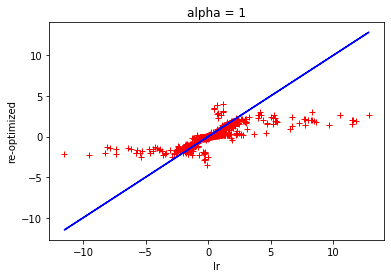

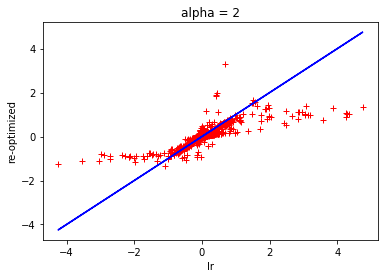

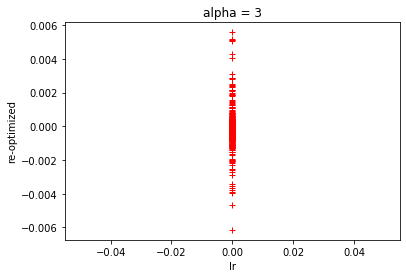

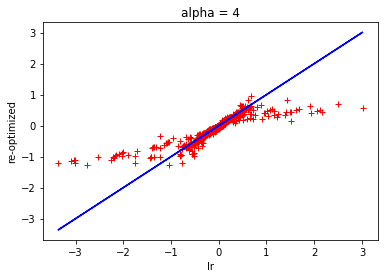

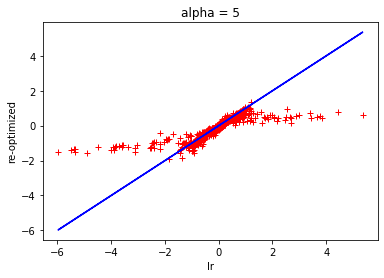

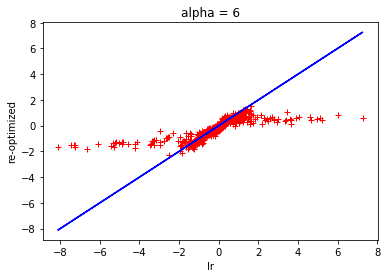

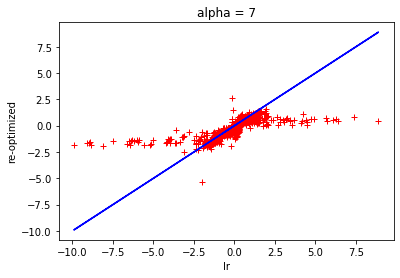

In [42]:
for i in range(len(alpha_list)): 
    plt.figure()
    print_diff_plot(lr_list[i], vb_pert_list[i], vb_opt)
    
    plt.title('alpha = {}'.format(alpha_list[i]))


# Number of clusters

In [43]:
lr_e_num_clusters_vec = np.zeros(len(alpha_list))
refit_e_num_clusters_vec = np.zeros(len(alpha_list))

for i in range(len(alpha_list)): 
    
    # get dictionaries
    pert_dict = vb_params_paragami.fold(vb_pert_list[i], free = True)
    lr_dict = vb_params_paragami.fold(lr_list[i], free = True)
    
    # get posterior expectations
    pert_e_ind_admix, pert_e_pop_freq = get_vb_expectations(pert_dict, use_logitnormal_sticks)
    lr_e_ind_admix, lr_e_pop_freq = get_vb_expectations(lr_dict, use_logitnormal_sticks)
    
    # get number of clusters
    refit_e_num_clusters_vec[i] = cluster_quantities_lib.get_e_num_clusters_from_ez(pert_e_ind_admix)
    lr_e_num_clusters_vec[i] = cluster_quantities_lib.get_e_num_clusters_from_ez(lr_e_ind_admix)


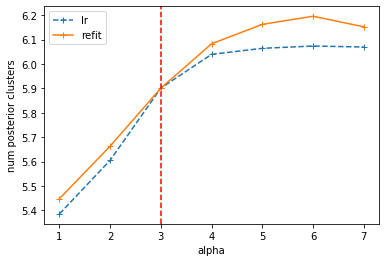

In [44]:
plt.plot(alpha_list, lr_e_num_clusters_vec, '+--')
plt.plot(alpha_list, refit_e_num_clusters_vec, '+-')

plt.xlabel('alpha')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))

plt.axvline(prior_params_dict['dp_prior_alpha'], color = 'red', linestyle = 'dashed')